In [2]:
import os
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from skimage import draw

import pytorch_lightning as pl
import torch
import torchvision
from torchvision import transforms as T
import segmentation_models_pytorch as smp


from torch.utils.data import Dataset, DataLoader, Subset

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from scipy.ndimage import label

In [3]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    GaussNoise, MotionBlur, MedianBlur, PiecewiseAffine,
    Sharpen, Emboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, Normalize, Resize, RandomBrightnessContrast
)
from albumentations.pytorch import ToTensorV2

def get_transforms(mode='val'):
    
    if mode == 'train':
        return Compose([
            Resize(512, 512),
            GaussNoise(p=0.3),
            OneOf([
                MotionBlur(p=0.2),
                MedianBlur(blur_limit=3, p=0.1),
                Blur(blur_limit=3, p=0.1),
            ], p=0.2),
            OneOf([
                OpticalDistortion(p=0.3),
                GridDistortion(p=0.1),
                PiecewiseAffine(p=0.3),
            ], p=0.2),
            OneOf([
                Sharpen(),
                Emboss(),
                RandomBrightnessContrast(),
            ], p=0.3),
            HueSaturationValue(p=0.3),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    return Compose([
        Resize(512, 512),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

In [10]:
BASE_FILENAME = '../data/'
BATCH_SIZE = 16
NUM_WORKERS = 5
# BASE_FILENAME = '/kaggle/input/hubmap-hacking-the-human-vasculature'

In [37]:
class HubmapDataset(Dataset):

    def __init__(self, image_dir, json_labels, transforms):
        self.json_labels = json_labels
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.json_labels)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = np.array(Image.open(image_path))

        mask = np.zeros((512, 512), dtype=np.float32)
        for annot in self.json_labels[idx]['annotations']:
            cords = annot['coordinates']
            if annot['type'] == "blood_vessel":
                for cord in cords:
                    rr, cc = np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord])
                    rr, cc = draw.polygon(rr, cc)
                    mask[rr, cc] = 1

        sample = self.transforms(image=image, mask=mask)
        return sample

In [38]:
train_transforms = get_transforms(mode='train')
val_transforms = get_transforms(mode='val')

In [39]:
with open(f'{BASE_FILENAME}/polygons.jsonl', 'r') as json_file:
    json_labels = [json.loads(line) for line in json_file]


In [40]:
train_labels, val_labels = train_test_split(json_labels, test_size=0.3, random_state=42)

In [41]:
train_dataset = HubmapDataset(f'{BASE_FILENAME}/train', train_labels, train_transforms)
val_dataset = HubmapDataset(f'{BASE_FILENAME}/train', val_labels, val_transforms)

In [42]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [49]:
def plot_sample(image, mask):

    image = image.permute(1, 2, 0).numpy()
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225]) 
    image = (image * std) + mean


    masked = image.copy()
    masked[mask == 1] = [1, 0, 0]  # Red color for mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(masked)
    ax[1].set_title('Image with mask')

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    plt.show()


In [50]:
image, mask = train_dataset[5].values()

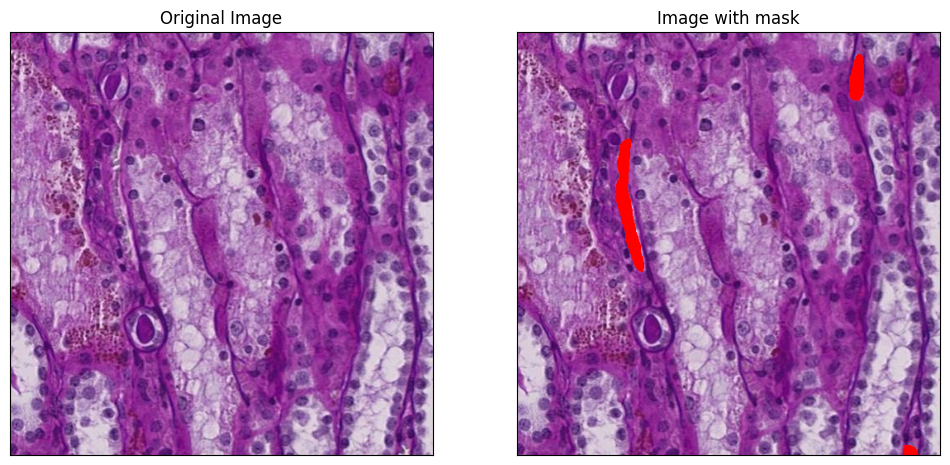

In [51]:
plot_sample(image, mask)

In [87]:
class LitModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=3, classes=1, **kwargs
        )

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, batch):
        # normalize image here
        image = batch["image"]
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        mask = batch["mask"].unsqueeze(1)
        logits_mask = self.forward(batch)
        loss = self.loss_fn(logits_mask, mask)


        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        self.log(f"loss/{stage}", loss)
        self.log(f"iou/{stage}", per_image_iou)

        
        return {
            "loss": loss,
            "iou": per_image_iou,
        }
    
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, 'val')
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3)

In [88]:
arch = 'UnetPlusPlus' 
encoder_name = 'efficientnet-b7'    

In [89]:
name = f'{arch}+{encoder_name}'

In [90]:
# smp.encoders.get_encoder_names()

In [91]:
model = LitModel(arch, encoder_name)

In [92]:
trainer = pl.Trainer(
    accelerator='gpu',
    devices=[0],
    max_epochs=100,
    logger=pl.loggers.TensorBoardLogger("../tb_logs", name=name),
    log_every_n_steps=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [93]:
trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]

  | Name    | Type         | Params
-----------------------------------------
0 | model   | UnetPlusPlus | 68.2 M
1 | loss_fn | DiceLoss     | 0     
-----------------------------------------
68.2 M    Trainable params
0         Non-trainable params
68.2 M    Total params
272.654   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/worker/anaconda3/envs/py/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
trainer.model.model.state_dict()

In [129]:
i = 1
torch.save(trainer.model.model.state_dict(), f"../checkpoints/{arch}/{encoder_name}/{i}.pth")

In [126]:
ckpt = torch.load("model_weights.pth")

In [ ]:
state = torch.load(model_path, map_location=CFG.device)

In [130]:
new = smp.create_model(arch, encoder_name, activation='sigmoid')

In [131]:
new.load_state_dict(torch.load(f"../checkpoints/{arch}/{encoder_name}/{i}.pth"))

<All keys matched successfully>